# 从MICAPS Cassandra Server数据库读取数值模式、卫星雷达等数据

#### —— nmc_met_io程序库使用说明

国家气象中心天气预报技术研发室    
June, 2020    
Kan Dai 


MICAPS分布式数据环境（BDIPS）提供WEBService API方式来检索数据. [nmc_met_io](https://github.com/nmcdev/nmc_met_io)程序库的[retrieve_micaps_server](https://github.com/nmcdev/nmc_met_io/blob/master/nmc_met_io/retrieve_micaps_server.py)模块, 基于WEBService API接口实现了Python语言对BDIPS数据的检索和读取.

### retrieve_micaps_server模块主要功能:
* 使用WEBService API接口, 无需额外的MICAPS Cassandra Server读取程序库;
* 引入的本地文件缓存技术, 加快数据的快速读取;
* 支持模式数据标量场, 矢量场及集合成员数据的读取; 
* 支持模式单点时间序列, 单点廓线及廓线时序的读取;
* 支持站点, 探空观测数据的读取;
* 支持awx格式的静止气象卫星等经纬度数据读取;
* 支持LATLON格式的雷达拼图数据读取;
* 统一的返回数据类型, 格点数据返回为[xarray](http://xarray.pydata.org/en/stable/)类型, 站点数据返回为[pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)类型.

### 参考网站
* https://github.com/nmcdev/nmc_met_io
* http://www.micaps.cn/MifunForum/topic/list?fId=7
---

## 1. 安装和配置nmc_met_io程序库

* 建议安装[Anaconda](https://www.anaconda.com/distribution/)的Python环境.
* [nmc_met_io](https://github.com/nmcdev/nmc_met_io)有详细安装说明.

In [1]:
# set up things
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
# load necessary libraries
# you should install cartopy with 'conda install -c conda-forge cartopy'
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

# load nmc_met_io for retrieving micaps server data
from nmc_met_io.retrieve_micaps_server import get_model_grid, get_model_grids, get_fy_awx

xr.set_options(display_style="text")

## 2. 读取数值模式预报数据

模块`retrieve_micaps_server`提供读取数值模式网格预报数据的函数:
 * `get_model_grid`: 读取单个时次标量, 矢量或集合成员的2D平面预报数据;
 * `get_model_grids`: 读取多个时次标量, 矢量或集合成员的2D平面预报数据;
 * `get_model_points`: 获取指定经纬度点的模式预报数据;
 * `get_model_3D_grid`: 获得单个时次标量, 矢量或集合成员的[lev, lat, lon]3D预报数据;
 * `get_model_3D_grids`: 获得多个时次标量, 矢量或集合成员的[lev, lat, lon]3D预报数据;
 * `get_model_profiles`: 获得制定经纬度单点的模块廓线预报数据.

每个函数都有固定的参数`directory`和`filename`(或`filenames`), 例如
```Python
# MICAPS分布式服务器上的数据地址, 可通过MICAPS4的数据源检索界面查找,
# 如下图, 找到数据存放的目录, 鼠标右键点击"保存路径到剪切板", 粘贴去掉"mdfs:///"
directory = 'ECMWF_HR/TMP/850'
# 指定具体的数据文件, 一般格式为"起报时间.预报时效", 若不指定, 则自动获得目录下最新数据的文件名
filename = '18021708.024'
# 调用函数读取数据
data = get_model_grid(directory, filename=filename)
```

<img src="./images/micaps_retrieve_UI.png" alt="image" style="height: 400px;">

### 2.1 读取单个时次模式标量预报数据

In [4]:
directory = 'ECMWF_HR/TMP/850'
filename = '21050808.024'
data = get_model_grid(directory, filename=filename, cache=False)
if data is not None:
    print(data)
else:
    print("Retrieve failed.")

<xarray.Dataset>
Dimensions:                  (lat: 301, level: 1, lon: 651, time: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2021-05-09T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 6.735e-06 0.2 0.4 ... 59.6 59.8 60.0
  * lon                      (lon) float64 50.0 50.2 50.4 ... 179.6 179.8 180.0
    forecast_reference_time  datetime64[ns] 2021-05-08T08:00:00
    forecast_period          (time) float64 24.0
Data variables:
    data                     (time, level, lat, lon) float32 19.18 ... -2.792
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server


<div class="alert alert-success">
    <b>返回xarray数据结构</b>:
    <ul>
        <li>返回的数据类型为[xarray](http://xarray.pydata.org/en/stable/)的Dataset结构数据(如下图所示).</li>
        <li>xarray为在numpy数组基础上增加维度, 坐标和属性信息, 其数据模型来自于netCDF文件结构.</li>
        <li>xarray提供直观,简介且可靠的格点数据操作功能, 已成为地球环境科学的标准数据处理程序库, 与很多现有的开源软件兼容.</li>
        <li><em>get_model_grid</em>根据读取数据类型返回不同维度的Dataset数据. 如上对于高空数据, 返回数据的维度分别为(time, level, lat, lon).</li>
        <li>在坐标Coordinate信息中, 除了数组维度的信息, 还给出起报时间forecast_reference_time和预报时效forecast_period</li>
    </ul>
</div>

<img src="./images/xarray_dataset.png" width="600">

In [4]:
# 使用?可以获得函数的帮助信息.
?get_model_grid

Signature:
get_model_grid(
    directory,
    filename=None,
    suffix='*.024',
    varname='data',
    varattrs={'units': ''},
    scale_off=None,
    levattrs={'long_name': 'pressure_level', 'units': 'hPa', '_CoordinateAxisType': 'Pressure'},
    cache=True,
    cache_clear=True,
)
Docstring:
Retrieve numeric model grid forecast from MICAPS cassandra service.
Support ensemble member forecast.

:param directory: the data directory on the service
:param filename: the data filename, if none, will be the latest file.
:param suffix: the filename filter pattern which will be used to
               find the specified file.
:param varname: set variable name.
:param varattrs: set variable attributes, dictionary type.
:param scale_off: [scale, offset], return values = values*scale + offset.
:param levattrs: set level coordinate attributes, diectionary type.
:param cache: cache retrieved data to local directory, default is True.
:return: data, xarray type

:Examples:
>>> data = get_model_grid(

In [5]:
# 可以指定数据的变量名称, 变量属性等信息
data = get_model_grid(directory, filename=filename, varname='TEM', varattrs={'long_name':'temperature', 'units':'degree'}, cache=False)
if data is not None:
    print(data.TEM)
else:
    print("Retrieve failed.")

<xarray.DataArray 'TEM' (time: 1, level: 1, lat: 301, lon: 651)>
array([[[[18.16605  , 18.1973   , 18.0723   , ..., 17.8848   ,
          17.91605  , 17.79105  ],
         [18.1348   , 18.0098   , 17.9473   , ..., 17.7598   ,
          17.72855  , 17.60355  ],
         [18.04105  , 17.9473   , 18.0098   , ..., 17.6973   ,
          17.60355  , 17.5098   ],
         ...,
         [-1.3652002, -1.3652002, -1.3652002, ..., -4.64645  ,
          -4.64645  , -4.7402   ],
         [-1.5214502, -1.5214502, -1.4277002, ..., -4.6152   ,
          -4.64645  , -4.77145  ],
         [-1.6464502, -1.6464502, -1.5527002, ..., -4.6777   ,
          -4.77145  , -4.89645  ]]]], dtype=float32)
Coordinates:
  * time                     (time) datetime64[ns] 2021-04-25T08:00:00
  * level                    (level) float32 850.0
  * lat                      (lat) float64 6.735e-06 0.2 0.4 ... 59.6 59.8 60.0
  * lon                      (lon) float64 50.0 50.2 50.4 ... 179.6 179.8 180.0
    forecast_referen

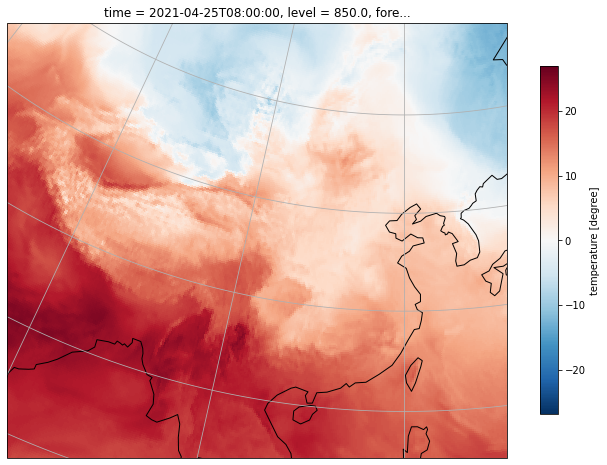

In [6]:
# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=120))
data.TEM.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())

## 2.2 读取多个时次的模式预报数据

In [7]:
%time
directory = "GRAPES_GFS/HGT/500/"
fhours = np.arange(0, 132, 12)
filenames = ['21042420.'+'%03d'%(fhour) for fhour in fhours]
data = get_model_grids(directory, filenames, varname='HGT', varattrs={'long_name':'geopotential height', 'units':'dagpm'}, cache=False)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.81 µs


In [8]:
data

<xarray.Dataset>
Dimensions:                  (lat: 360, level: 1, lon: 721, time: 11)
Coordinates:
  * time                     (time) datetime64[ns] 2021-04-24T20:00:00 ... 20...
  * level                    (level) float32 500.0
  * lat                      (lat) float64 -9.875 -9.625 -9.375 ... 79.62 79.88
  * lon                      (lon) float64 0.0 0.25 0.5 ... 179.5 179.8 180.0
    forecast_reference_time  datetime64[ns] 2021-04-24T20:00:00
    forecast_period          (time) float64 0.0 12.0 24.0 ... 96.0 108.0 120.0
Data variables:
    HGT                      (time, level, lat, lon) float32 587.7 ... 512.7
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

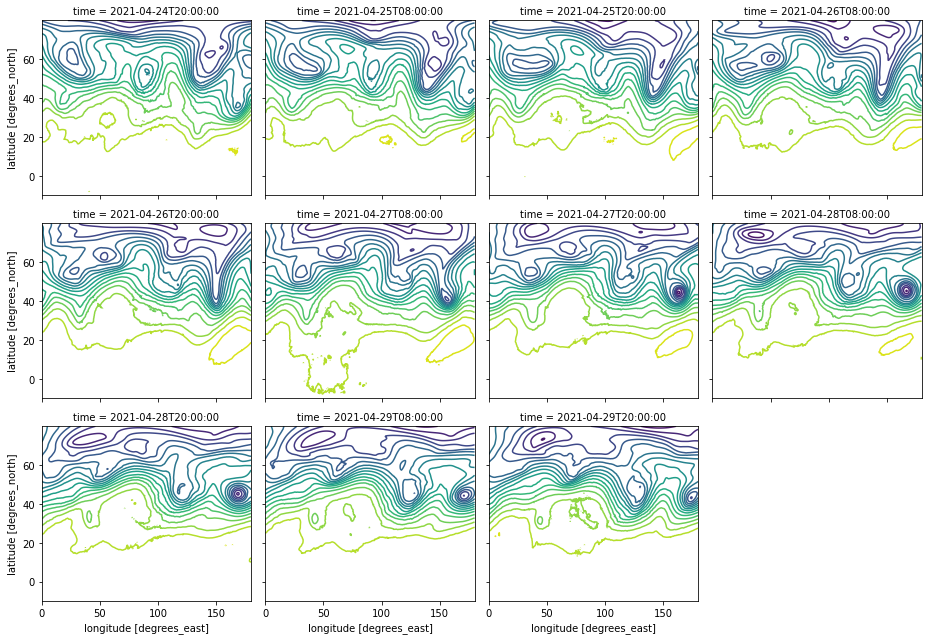

In [9]:
# 绘制图像
data.HGT.isel(level=0).plot.contour(col='time', col_wrap=4, levels=20)

## 2.3 读取集合预报数据

In [10]:
%time
directory = "ECMWF_ENSEMBLE/RAW/RAIN24/"
filename = "21042420.036"
data = get_model_grid(directory, filename=filename, varname='precipitation',
                      varattrs={'long_name':'accumulated precipitation', 'units':'mm'},
                      cache=False)
data

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


<xarray.Dataset>
Dimensions:                  (lat: 121, lon: 261, number: 51, time: 1)
Coordinates:
  * number                   (number) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
  * time                     (time) datetime64[ns] 2021-04-26T08:00:00
  * lat                      (lat) float64 0.0 0.5 1.0 1.5 ... 59.0 59.5 60.0
  * lon                      (lon) float64 50.0 50.5 51.0 ... 179.0 179.5 180.0
    forecast_reference_time  datetime64[ns] 2021-04-24T20:00:00
    forecast_period          (time) float64 36.0
Data variables:
    precipitation            (number, time, lat, lon) float64 2.102 ... 0.1698
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

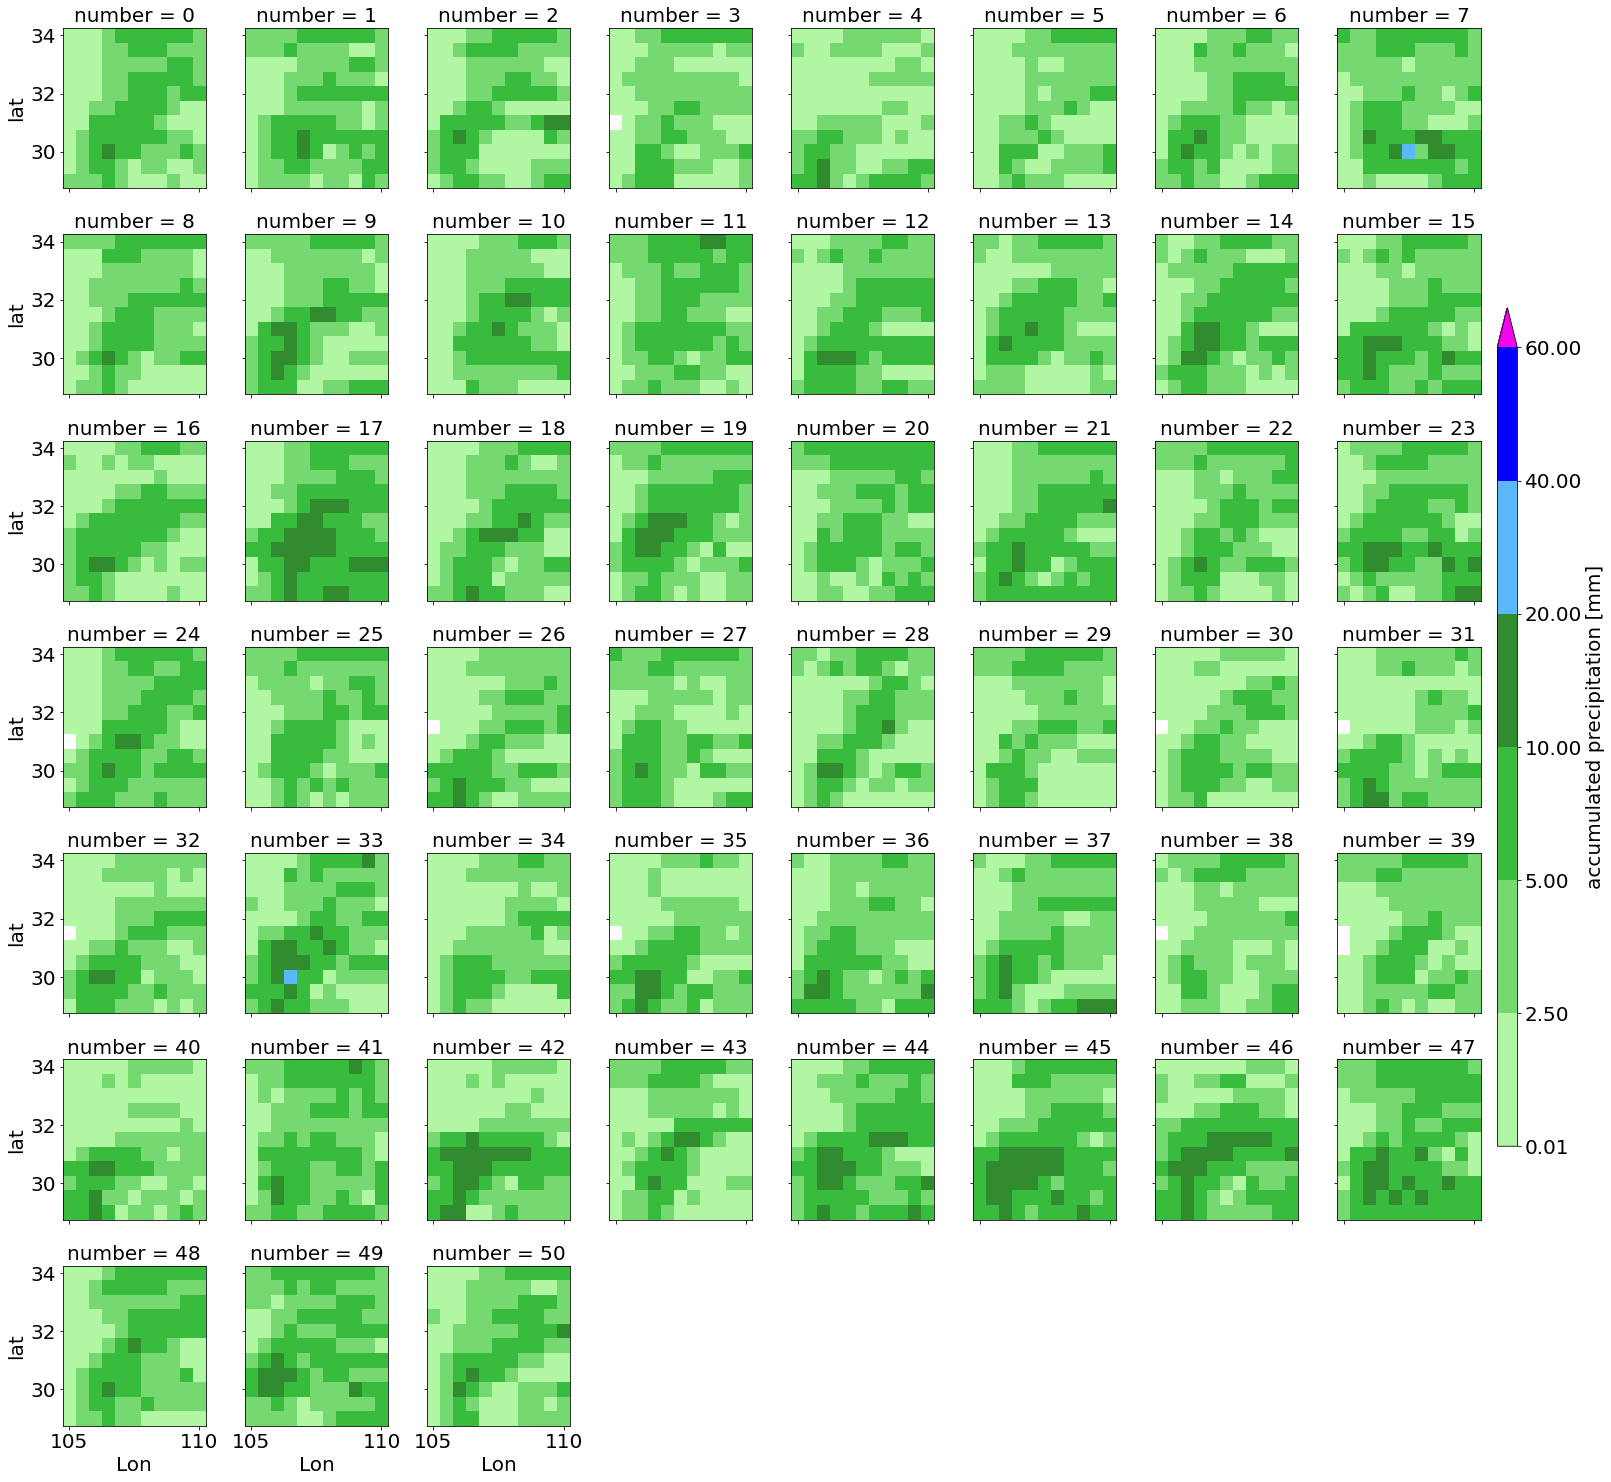

In [11]:
# set colors and levels
clevs = [0.01, 2.5, 5, 10, 20, 40, 60]
colors = ['#b1f7a3', '#76d870', '#39bb3e', '#318c2f', '#5cb8fc', '#0202fd', '#ef08e9']
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')

plt.rcParams['font.size'] = '20'
subdata = data.sel(lon=slice(105, 110), lat=slice(29, 34))
fg = subdata.precipitation.isel(time=0).plot(
    col='number', col_wrap=8, cmap=cmap, norm=norm, extend="max", \
    sharex=True, sharey=True,
    cbar_kwargs={"aspect":40, "shrink":0.6, "pad":0.01})
fg.set_xlabels("Lon")
fg.set_ylabels("lat")

## 2.4 读取卫星图像数据

In [15]:
# 获得风云4A中国区域4通道产品
directory = "SATELLITE/FY4A/L1/CHINA/C008"
data = get_fy_awx(directory)
data

<xarray.Dataset>
Dimensions:  (time: 1, channel: 1, lat: 1001, lon: 1751)
Coordinates:
  * time     (time) datetime64[ns] 2021-12-09T14:19:00
  * channel  (channel) int16 5
  * lat      (lat) float64 15.0 15.04 15.08 15.12 ... 54.88 54.92 54.96 55.0
  * lon      (lon) float64 70.0 70.04 70.08 70.12 ... 139.9 139.9 140.0 140.0
Data variables:
    image    (time, channel, lat, lon) float64 296.8 296.8 296.8 ... 256.5 256.5
Attributes:
    Conventions:  CF-1.6
    Origin:       MICAPS Cassandra Server

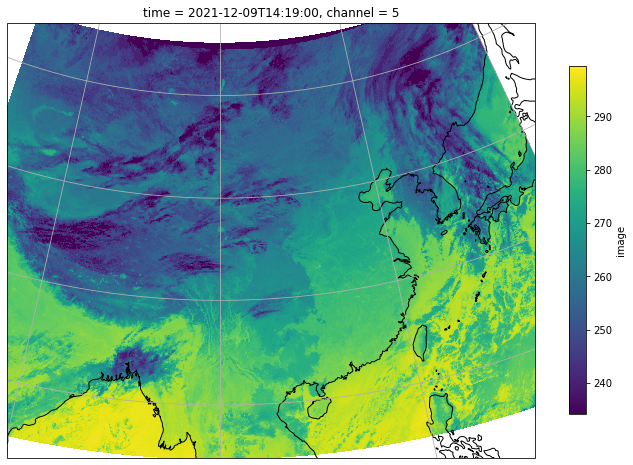

In [17]:
# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=100))
data.image[0,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())

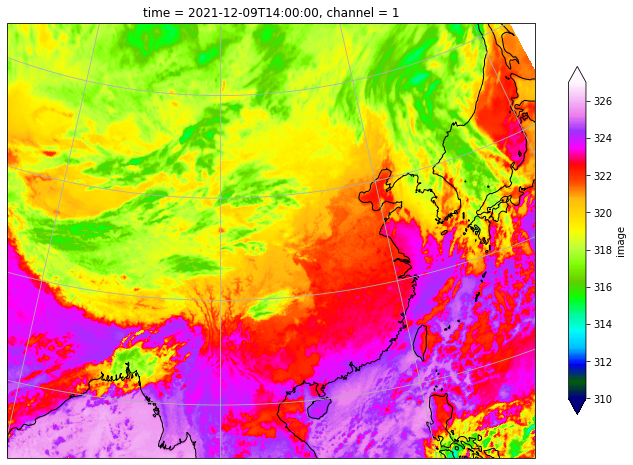

In [37]:
# 风云2静止卫星图像
directory = "SATELLITE/FY2/L1/IR1/EQUAL"
data = get_fy_awx(directory)

# 绘制图像
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=100))
data.image[0,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8}, cmap="gist_ncar", vmin=310, vmax=327)
ax.coastlines()
ax.gridlines()
ax.set_extent([80,130,15,54], crs=ccrs.PlateCarree())